# LSTM 학습

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.functional import F

base_dir = os.getcwd() + "/"

# base_dir = "/content/drive/MyDrive/bookend/dev/text-style-classify/basic/"

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

In [ ]:
df = pd.read_pickle(base_dir + 'data/labeled_compact.pkl')
df

In [ ]:
tokenized_sentences = df['tokenized_sentence']
labels = df['encoded_author'].tolist()

In [ ]:
vocab = Counter(token for sentence in tokenized_sentences for token in sentence)
vocab = {token: idx for idx, (token, _) in enumerate(vocab.items(), start=1)}  

import pickle
with open(base_dir + 'lstm_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

def encode(sentence, vocab):
    return [vocab[token] for token in sentence]

encoded_sentences = [encode(sentence, vocab) for sentence in tokenized_sentences]

In [ ]:
# 패딩 및 시퀀스 길이 설정
max_len = max(len(sentence) for sentence in encoded_sentences)
padded_sentences = [sentence + [0] * (max_len - len(sentence)) for sentence in encoded_sentences]

# 텐서 변환
X = torch.tensor(padded_sentences, dtype=torch.long)
y = torch.tensor(labels, dtype=torch.long)

# train과 validation 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터셋 및 데이터로더 정의
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5000, shuffle=False)

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1]
        out = self.fc1(h_n)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

vocab_size = len(vocab) + 1  # 패딩 토큰을 고려한 크기
embed_size = 256
hidden_size = 128
output_size = len(set(labels))  # 클래스 수

model = LSTMClassifier(vocab_size, embed_size, hidden_size, output_size)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    for i, (sentences, labels) in enumerate(tqdm(train_loader, desc='Training')):
        outputs = model(sentences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # 에포크 종료 후 평균 손실 출력
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # 검증 루프
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for sentences, labels in tqdm(val_loader, desc='Validation'):
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


In [ ]:
torch.save(model, base_dir + 'lstm_model.pt')

# LSTM 실행

In [14]:
import os, pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.functional import F


base_dir = os.getcwd() + "/"



    
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1]
        out = self.fc1(h_n)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out


class subLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(subLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1]
        out = self.fc1(h_n)
        return out
    

with open(base_dir + 'lstm_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

def encode(sentence, vocab):
    return [vocab[token] for token in sentence]

vocab_size = len(vocab) + 1  # 패딩 토큰을 고려한 크기
embed_size = 256
hidden_size = 128

model = torch.load(base_dir + 'lstm_model.pt')

sub_model = subLSTMClassifier(vocab_size, embed_size, hidden_size)

sub_model.embedding = model.embedding
sub_model.lstm = model.lstm
sub_model.fc1 = model.fc1


In [15]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
def tokenizing_encode(sentence):
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=64,
        padding="max_length",
        return_attention_mask=False,
        return_tensors='pt',
        truncation=True
    )
    tokens = encoding['input_ids'][0]
    token_list = tokenizer.convert_ids_to_tokens(tokens)
    return pd.Series(token_list)

def sent2vec(sentence):
    tokens = tokenizing_encode(sentence)
    encoded = torch.tensor(encode(tokens, vocab), dtype=torch.long).unsqueeze(0)
    with torch.no_grad():
        feature = model(encoded)
    return feature[0].numpy()


In [16]:
a = """우리 대학이 가수 지드래곤(본명 권지용) 씨를 기계공학과 초빙교수에 임명했다. 임명장 수여는 5일 오전스포츠컴플렉스에서 개최된 ‘이노베이트 코리아 2024’ 행사에서 진행됐다. 이번 임용은 우리 대학의 최신 과학기술을 K-콘텐츠와 문화산업에 접목해 한국 문화의 글로벌 경쟁력을 확대하고자 추진됐다. 

권 씨의 소속사인 갤럭시코퍼레이션 관계자는 "이번 임용은 '엔터테크*' 연구개발을 통한 시장 혁신과 K-컬처의 글로벌 확산과 성장에 기여할 것으로 기대된다"라고 밝혔다.

권지용 초빙교수는 학부생 및 대학원생을 대상으로 하는 리더십 특강으로 강단에 설 예정이다. 세계적인 아티스트로서의 경험과 삶을 공유해 우리 대학 구성원들이 세계를 바라보는 비전과 통찰, 각자의 영역을 개척하는 도전과 영감을 제공한다는 취지다. 또한, 문화행사를 개최해 구성원과 소통하는 한편, 창의적이고 융합적인 인재로 성장하는 데 필요한 예술적 경험을 제공할 예정이다. 

지드래곤으로 활동해온 권지용 교수는 2006년 데뷔해 세계적인 인기를 끈 아이돌 그룹 '빅뱅'의 멤버이자 리더로, 18년간 한국 대중문화를 상징하는 아이콘으로 자리잡았다. 작사, 작곡과 프로듀싱부터 공연까지 음악활동 전반에서 최고의 실력을 인정받는 한편, 2016년에는 아시아 남성 최초로 패션 브랜드 샤넬의 글로벌 엠버서더로 선정되는 등 패션 분야에서도 폭넓은 활약을 펼쳐 한국의 음악과 패션을 세계에 알렸다고 평가받는다. 국내 최초로 2017년 6월, 솔로 앨범 3집 '권지용'을 기존의 CD 형태가 아닌 USB로 앨범을 발매하기도 했으며, 올해 1월 미국 라스베이거스에서 열린 세계 최대 가전·IT 전시회 CES에 참석하는 등 '테크테이너'로서 행보를 넓혀가고 있다.


""".split('\n')
b = []

for i in a:
    b.extend(i.split('.'))

a = b.copy()
for i in a:
    b.extend(i.split('.'))
b = list(set(b))
list(set.difference(set(a), {"", " "}))


[' 임명장 수여는 5일 오전스포츠컴플렉스에서 개최된 ‘이노베이트 코리아 2024’ 행사에서 진행됐다',
 ' 세계적인 아티스트로서의 경험과 삶을 공유해 우리 대학 구성원들이 세계를 바라보는 비전과 통찰, 각자의 영역을 개척하는 도전과 영감을 제공한다는 취지다',
 '권 씨의 소속사인 갤럭시코퍼레이션 관계자는 "이번 임용은 \'엔터테크*\' 연구개발을 통한 시장 혁신과 K-컬처의 글로벌 확산과 성장에 기여할 것으로 기대된다"라고 밝혔다',
 '권지용 초빙교수는 학부생 및 대학원생을 대상으로 하는 리더십 특강으로 강단에 설 예정이다',
 "지드래곤으로 활동해온 권지용 교수는 2006년 데뷔해 세계적인 인기를 끈 아이돌 그룹 '빅뱅'의 멤버이자 리더로, 18년간 한국 대중문화를 상징하는 아이콘으로 자리잡았다",
 " 국내 최초로 2017년 6월, 솔로 앨범 3집 '권지용'을 기존의 CD 형태가 아닌 USB로 앨범을 발매하기도 했으며, 올해 1월 미국 라스베이거스에서 열린 세계 최대 가전·IT 전시회 CES에 참석하는 등 '테크테이너'로서 행보를 넓혀가고 있다",
 ' 작사, 작곡과 프로듀싱부터 공연까지 음악활동 전반에서 최고의 실력을 인정받는 한편, 2016년에는 아시아 남성 최초로 패션 브랜드 샤넬의 글로벌 엠버서더로 선정되는 등 패션 분야에서도 폭넓은 활약을 펼쳐 한국의 음악과 패션을 세계에 알렸다고 평가받는다',
 ' 이번 임용은 우리 대학의 최신 과학기술을 K-콘텐츠와 문화산업에 접목해 한국 문화의 글로벌 경쟁력을 확대하고자 추진됐다',
 '우리 대학이 가수 지드래곤(본명 권지용) 씨를 기계공학과 초빙교수에 임명했다',
 ' 또한, 문화행사를 개최해 구성원과 소통하는 한편, 창의적이고 융합적인 인재로 성장하는 데 필요한 예술적 경험을 제공할 예정이다']

In [30]:
woohyeon = \
['세상이 점점 좁아지고 있다',
 '과거에는 서울에서 부산까지 가려면 꼬박 15일이 걸렸지만, 오늘날에는 부산까지 4시간이면 기차를 타고 갈 수 있다',
 '사람 뿐만이 아니라 물건도 마찬가지다',
 '전날 보낸 이삿짐은 다음날이면 기숙사에 도착해있고, 오늘 저녁에 주문한 컵과일 세트는 내일 새벽이면 도착한다',
 '이렇듯 과거에는 15일 거리의 세상이 오늘날에는 몇시간~하루 거리의 세상이 되었다',
 ' 세상이 좁아진건 비단 사람이나 물건 같은 물리적 실체에만 적용되는 것은 아니다',
 ' 오히려, 정보의 세상은 더 극단적으로 줄어들었다',
 ' 당장 소셜 미디어를 켜봐라',
 ' 몇천 km 떨어진 우크라이나에서 벌어지는 전쟁 소식, 지구 반대편의 미국에서 벌어지는 정치 스캔들, 심지어는 아르헨티나의 학생이 앞구르기하다가 실패한 동영상까지 우리는 침대에 누워서 손가락질 몇번이면 이 모든 정보를 얻을 수 있다',
 ' 정보에 있어서, 세상은 이제 몇초 거리의 세상이다',]

news1 = \
['과학영재선발제도는 과학기술 분야에 뛰어난 자질을 갖춘 학생들에게 우리 대학 조기 진학의 기회를 제공하는 제도로 과학고·일반고·자율고 2학년 수료 예정자를 대상으로 운영되고 있다. ',
 '우리 대학 동문인 장병규 크래프톤 의장과 김범준 네이버 최고운영책임자는 과학고 2학년 때 이 제도를 활용해 입학했으며, 인공지능 분야의 석학으로 신경망 기계 번역 알고리즘을 개발한 조경현 뉴욕대 교수도 일반고 2학년 재학 중에 자격을 얻어 입학했다. ',
 '이 제도를 통해 선발된 과학영재 학생은 고등학교 2학년 때 3학년 학생과 함께 우리 대학 학사과정 입시전형에 응시할 수 있는 자격을 부여받게 되며, 해당연도 입시전형에서 최종 합격했을 때 조기입학이 가능하다. ',
 '제출 서류도 간소화된다. 학교생활기록부·고등학교 성적증명서를 포함해 최대 6종까지 요구되던 서류는 지원서 및 자기소개서와 학교장 추천서 총 2종으로 줄어든다. ',
 '최근 3년간 341명이 과학영재선발제도에 지원해 93.5%인 319명이 선발됐으며, 이 중 130명이 학사과정 입시전형에 최종 합격했다. 합격 후 우리 대학에 등록한 경우 초·중등교육법 시행령에 따라 남은 고교과정을 마치지 않아도 고졸 학력을 인정받게 된다. ',
 '변경된 제도를 적용할 경우, 수학·과학·정보 과목(과학기술 분야) 중 어느 한 과목의 한 학기 석차 백분위가 일정 기준* 이상이거나 전국 단위 이상의 창의연구(Research & Education)·과학전람회·올림피아드·기타 연구활동 대회 입상한 이력이 있으면 소속 학교장의 추천을 받아 지원할 수 있다. *일반고·자율고·기타학교: 과목 석차 백분위 90% 이상(상위 10% 이내), 과학고·영재학교: 과목 석차 백분위 70% 이상(상위 30% 이내)',
 '"우리 대학이 15일 오전 10시 30분 대전 본원 대강당에서 과학영재선발제도 설명회를 개최한다.',
 '이번 설명회는 올해 1월 국무회의를 통과한 과학영재선발제도의 개정안을 수험생과 학부모 및 교사에게 안내하기 위해 마련된 자리다. 기존 대상 외에도 영재교육진흥법에 따른 영재학교 재학생과 영재교육특례자의 지원을 허용하고 제출 서류를 간소화한 것이 개정안의 골자다. ',
 '입학전형팀 관계자는 "과학고 학생만 KAIST 학사과정에 조기 진학하는 것으로 알고 계신 분들이 많은데, 일반고나 자율고 학생에게도 기회는 늘 열려있다"라며, "학교 유형에 상관없이 지원할 수 있도록 자격 기준을 확대하고 지원 절차도 간소화해 KAIST 조기 진학의 혜택을 더 많은 학생이 누릴 수 있도록 제도를 개정한 것"이라고 설명했다. ',
 '김용현 KAIST 입학처장은  "일반고·자율고 등에 재학 중인 2학년 학생의 KAIST 과학영재선발제도 지원자 수가 최근 3년간 5배가량 증가했다"라며, "KAIST는 과학영재선발제도 중심으로 우수 이공계 인재들의 조기졸업·조기진학 혜택을 확대 개편할 예정"이라고 설명했다.']


woohyeon2 = \
[ "시장주의는 '최대 다수의 최대 효용'이라는 가치에 의해 작동합니다",
 '즉, 자원의 효율적 분배라는 시장적 가치 외의 다른 소중한 가치가 있음을 지적하며 시장주의의 무제한적 확장을 비판하는 것입니다',
 '평범한 상품을 거래하는 데 이것보다 효율적인 방법은 없기 때문이죠',
 '사람을 사고 파는 것은 인간의 존엄이라는 가치를 훼손하기 때문에 그러한 행위는 옳지 못하다는 것이지요',
 '이러한 시장주의는 굉장히 강력해, 오늘날에는 경제학의 절대 법칙으로 여겨짐과 동시에, 거의 모든 분야에서 시장주의를 통해 문제를 해결하고 있죠',
 '사실, 연필을 사고 파는사고파는 것에 시장주의를 반박하는 사람은 거의 없습니다',
 '마이클 샌델은 이를 단호하게 반박합니다',
 '이런식으로 샌델은 우리 삶에 침습해 소중한 가치를 훼손하고 있는 시장주의를 하나하나 찾아 시장주의를 반박합니다',
 '예를 들어, 학용품점에서 연필을 한 다스에 3000원에 팔고, 그걸 제가 샀다면, 학용품점에서는 마진을 통해 이윤을 남겨서 좋고, 제 입장에선 필요한 학용품을 살 수 있어서 좋기 때문에 거래가 이루어졌으며, 이러한 거래가 자유롭게 이뤄질 때 시장 전체의 효율이 극대화된다는 것입니다',
 '즉, 거래 당사자가 모두 만족하는 거래는 전체 효용을 증가시켜, 시장 전체로 봤을 때 알짜 효용이 극대화된다는 것입니다',]


news2 = \
[' 임명장 수여는 5일 오전스포츠컴플렉스에서 개최된 ‘이노베이트 코리아 2024’ 행사에서 진행됐다',
 '권 씨의 소속사인 갤럭시코퍼레이션 관계자는 "이번 임용은 \'엔터테크*\' 연구개발을 통한 시장 혁신과 K-컬처의 글로벌 확산과 성장에 기여할 것으로 기대된다"라고 밝혔다',
 '또한, 문화행사를 개최해 구성원과 소통하는 한편, 창의적이고 융합적인 인재로 성장하는 데 필요한 예술적 경험을 제공할 예정이다',
 '세계적인 아티스트로서의 경험과 삶을 공유해 우리 대학 구성원들이 세계를 바라보는 비전과 통찰, 각자의 영역을 개척하는 도전과 영감을 제공한다는 취지다',
 "지드래곤으로 활동해온 권지용 교수는 2006년 데뷔해 세계적인 인기를 끈 아이돌 그룹 '빅뱅'의 멤버이자 리더로, 18년간 한국 대중문화를 상징하는 아이콘으로 자리잡았다",
 "국내 최초로 2017년 6월, 솔로 앨범 3집 '권지용'을 기존의 CD 형태가 아닌 USB로 앨범을 발매하기도 했으며, 올해 1월 미국 라스베이거스에서 열린 세계 최대 가전·IT 전시회 CES에 참석하는 등 '테크테이너'로서 행보를 넓혀가고 있다",
 '권지용 초빙교수는 학부생 및 대학원생을 대상으로 하는 리더십 특강으로 강단에 설 예정이다',
 '작사, 작곡과 프로듀싱부터 공연까지 음악활동 전반에서 최고의 실력을 인정받는 한편, 2016년에는 아시아 남성 최초로 패션 브랜드 샤넬의 글로벌 엠버서더로 선정되는 등 패션 분야에서도 폭넓은 활약을 펼쳐 한국의 음악과 패션을 세계에 알렸다고 평가받는다',
 '우리 대학이 가수 지드래곤(본명 권지용) 씨를 기계공학과 초빙교수에 임명했다',
 '이번 임용은 우리 대학의 최신 과학기술을 K-콘텐츠와 문화산업에 접목해 한국 문화의 글로벌 경쟁력을 확대하고자 추진됐다']

In [31]:
data = {
    'woohyeon1': woohyeon,
    'news1': news1,
    'woohyeon2': woohyeon2,
    'news2': news2
}

for key, value in data.items():
    temp = []
    for sentence in value:
        temp.append(sent2vec(sentence))
    data[key] = temp

all_data = np.vstack(list(data.values()))

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import MinMaxScaler


In [33]:
# UMAP 초기화
umap_reducer = umap.UMAP(n_components=2, random_state=1210)

# UMAP 적용
transformed_all_data = umap_reducer.fit_transform(all_data)

# 결과를 원래의 데이터셋으로 분할
umap_results = {}
start = 0
for key, array in data.items():
    array = np.array(array)  # 리스트를 np.array로 변환
    end = start + array.shape[0]
    umap_results[key] = transformed_all_data[start:end]
    start = end


/home/hasha/anaconda3/envs/AI/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


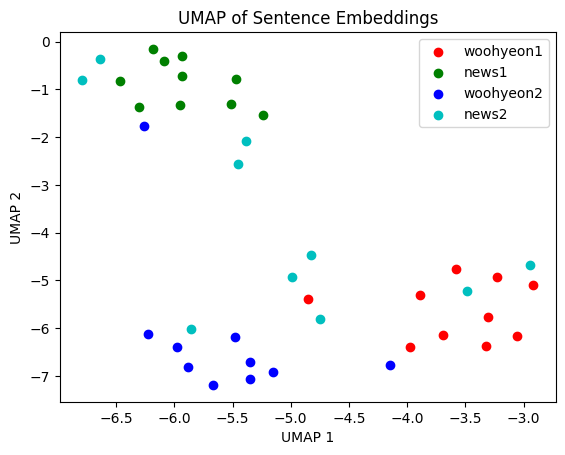

In [35]:
# 색상 목록
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for i, (key, transformed_array) in enumerate(umap_results.items()):
    color = colors[i % len(colors)]
    plt.scatter(transformed_array[:, 0], transformed_array[:, 1], c=color, label=key)

plt.legend()
plt.title('UMAP of Sentence Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()